In [1]:
%matplotlib notebook

# Stock Price Predictions

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from alpha_vantage.timeseries import TimeSeries
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Conv1D, Flatten, MaxPooling1D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
import tools_for_prediction as tfp
from keras.utils import to_categorical
from sklearn.metrics import f1_score, mean_squared_error
import time

Using TensorFlow backend.


In [3]:
# parameters
to_use = ['XOM', 'DAL', 'AAPL', 'GOOGL', 'MSFT']
# to_use = ['AAPL']
to_predict = 'AAPL'

# x_len = 30
x_len = 100

y_len = 10
# y_len = 30

n_features = len(to_use)

alpha_vantage_key = 'K1M63RZKLZKLDHXD'

# problem_type = 'regression'
# type_prediction = 'exact_numbers'

problem_type = 'classification'
type_prediction = 'up_or_down'

past_importance = 'alternate'
nb_period=10
# past_importance = 'shuffle'
seed=0
# past_importance = 'time-consistent'

## Loading data

In [4]:
prices_df = tfp.loading_mid_prices(alpha_vantage_key, to_use, to_predict )

Processing XOM
Processing DAL
Processing AAPL
Processing GOOGL
Processing MSFT


In [6]:
tfp.visualize_stocks(prices_df)

<IPython.core.display.Javascript object>

Prediction via averaging (one-step ahead)

In [52]:
x_stav=prices_df['AAPL'].copy()

a=time.time()

window_size = 10
N = len(x_stav)
std_avg_predictions = []

for i in range(0, N):
    
    if i < window_size:
        std_avg_predictions.append(np.mean(x_stav[0:i]))
    else:
        std_avg_predictions.append(np.mean(x_stav[i-window_size:i]))

std_avg_predictions[0]=x_stav[0]
        

m=tfp.nmse_metric_for_np(x_stav, std_avg_predictions)

n=mean_squared_error(x_stav, std_avg_predictions)

b=time.time()

print("NMSE for standart averaging:", m)
print("Mean squared error for standard averaging:", n)
print('time elapsed:', b-a)
#print("Prediction for the next day: ", std_avg_predictions[-1])

NMSE for standart averaging: 0.005546365423254599
Mean squared error for standard averaging: 281.1596854165856
time elapsed: 1.8322947025299072


<IPython.core.display.Javascript object>


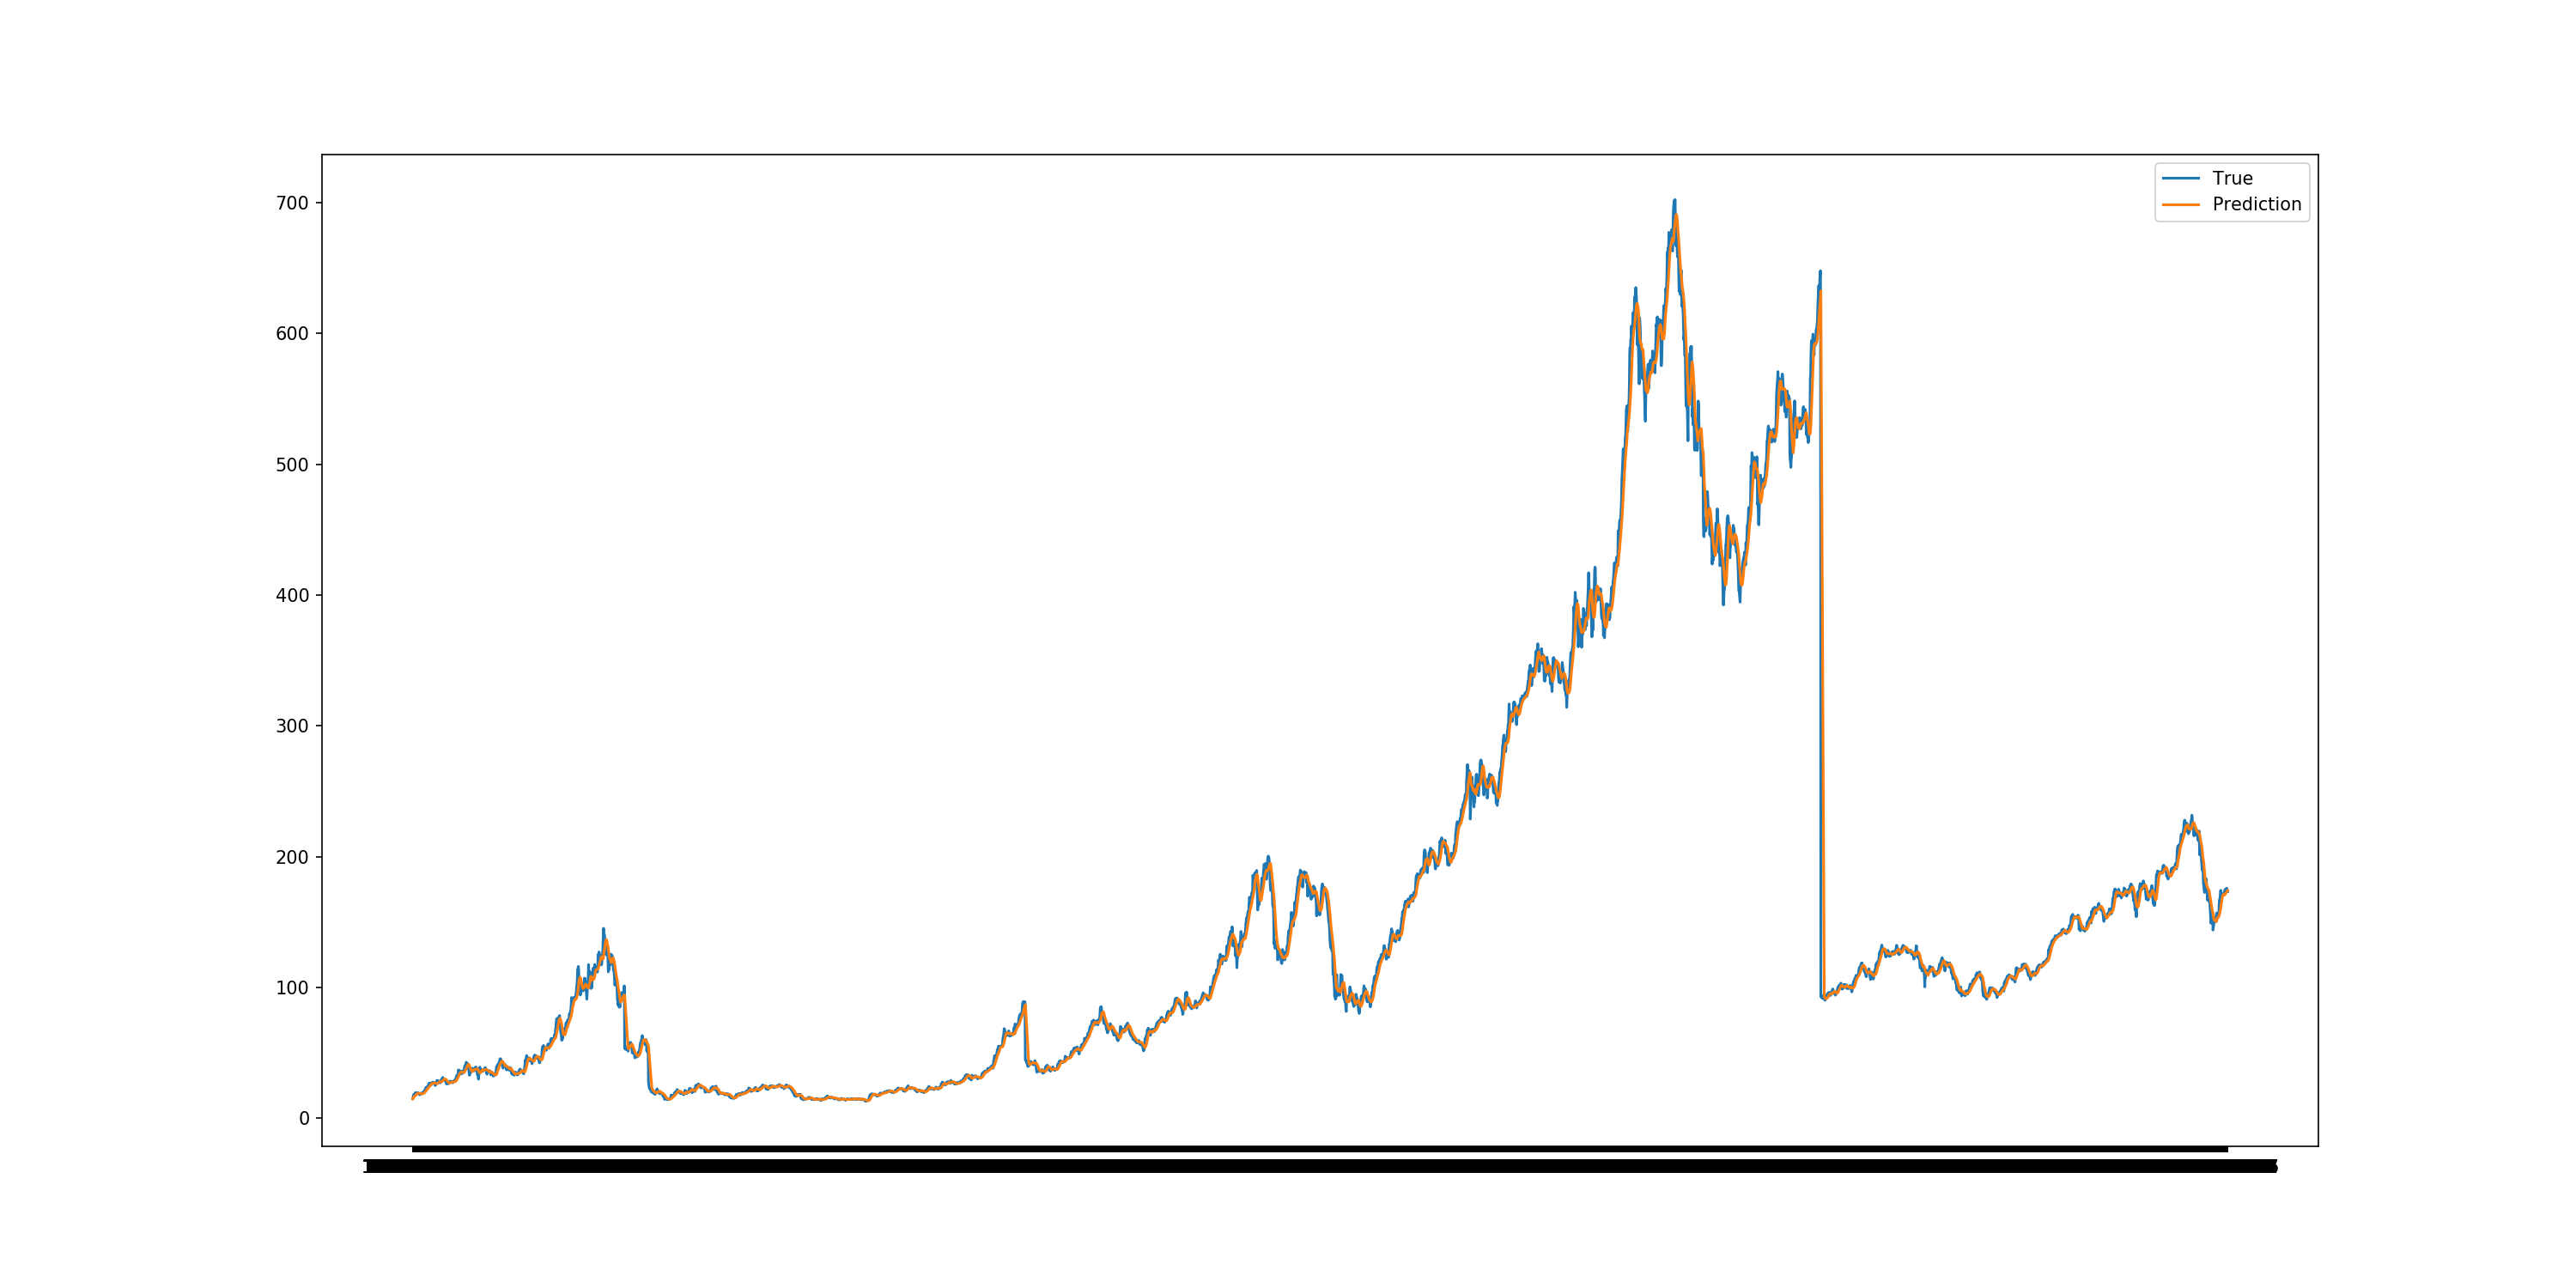

In [50]:
plt.figure(figsize=(20,10))
plt.plot(x_stav, label='True')
plt.plot(std_avg_predictions, label='Prediction')
plt.legend()
plt.show()

Exponential Moving Average

In [49]:
a=time.time()

smoothing_coefficient = 0.4

N = len(x_stav)

model = SimpleExpSmoothing(x_stav)
model_fit = model.fit(smoothing_coefficient)
EMA_predictions = model_fit.predict(0, N)
EMA_predictions=EMA_predictions[1:]

n=mean_squared_error(x_stav, EMA_predictions)

m=tfp.nmse_metric_for_np(x_stav.values, EMA_predictions)

b=time.time()

print("NMSE for EMA:", m)
print("Mean squared error for EMA:", n)
print('Time elapsed:', b-a)
#print("Prediction for the next day: ", EMA_predictions[1])

NMSE for EMA: 0.0008105967685476146
Mean squared error for EMA: 41.09125797751937
Time elapsed: 0.16661572456359863


C:\Users\eliot\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\eliot\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [13]:
plt.figure(figsize=(20,10))
plt.plot(x_stav, label='True')
plt.plot(EMA_predictions, label='Prediction')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

## Regression

### Building the training, valiadation and testing datasets

In [14]:
#Using a sliding window model to build input and output time series
df = tfp.create_dataset(prices_df, to_predict, type_prediction, x_len, y_len)

#Dividing in train/val/test our data
(train,val,test) = tfp.split_train_val_test(df, model=past_importance, nb_period=nb_period, seed=seed)

# Reshaping our data so that they can be properly fed to out networks
x_train = tfp.to_multidim_array_train(train[to_use])
x_val =  tfp.to_multidim_array_train(val[to_use])
x_test =  tfp.to_multidim_array_train(test[to_use])
y_train =  tfp.to_multidim_array_y(train['y_' + to_predict])
y_val =  tfp.to_multidim_array_y(val['y_' + to_predict])
y_test =  tfp.to_multidim_array_y(test['y_' + to_predict])

TypeError: 'numpy.int64' object is not iterable

### CNN model 1 (x_len = 100)

In [ ]:
a = time.time()

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=4, activation='relu',  input_shape=(x_len, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(y_len, activation='relu'))
model.compile(optimizer='adam', loss='mse',  metrics=[tfp.nmse_metric, tfp.std_diff_metric])


print(model.summary())

model.fit(x_train, y_train, epochs=400, batch_size=32, verbose=1, validation_data=(x_val, y_val))

predictions = model.predict(x_test)

pred = pd.DataFrame({"index":test.index, "predictions":tfp.to_onedim_array(predictions)}).set_index('index')

tfp.visualize_predictions_training(prices_df, pred, x_len, y_len, problem_type)

b = time.time()
print("Training time = ", b-a)

In [ ]:
future_pred = model.predict(tfp.data_for_prediction(to_predict, prices_df, x_len))
print(future_pred)
df_final = tfp.add_predictions_to_vizualization(future_pred, prices_df, to_predict)

### CNN model 2 (x_len = 30)

In [ ]:
a = time.time()

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=4, activation='relu',  input_shape=(x_len, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(y_len, activation='relu'))
model.compile(optimizer='adam', loss='mse',  metrics=[tfp.nmse_metric, tfp.std_diff_metric])

print(model.summary())

model.fit(x_train, y_train, epochs=600, batch_size=32, verbose=1, validation_data=(x_val, y_val))

predictions = model.predict(x_test)

pred = pd.DataFrame({"index":test.index, "predictions":tfp.to_onedim_array(predictions)}).set_index('index')

tfp.visualize_predictions_training(prices_df, pred, x_len, y_len, problem_type)

b = time.time()
print("Training time = ", b-a)

In [ ]:
future_pred = model.predict(tfp.data_for_prediction(to_predict, prices_df, x_len))
print(future_pred)
df_final = tfp.add_predictions_to_vizualization(future_pred, prices_df, to_predict)

### LSTM Model (Put a small x_len (<30-35))

In [ ]:
a = time.time()

model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(x_len, n_features)))
model.add(LSTM(128, activation='relu'))
model.add(Dense(y_len, activation='relu'))
model.compile(optimizer="adam", loss='mse',  metrics=[tfp.nmse_metric, tfp.std_diff_metric])


print(model.summary())

model.fit(x_train, y_train, epochs=400, batch_size=32, verbose=1, validation_data=(x_val, y_val))

predictions = model.predict(x_test)

pred = pd.DataFrame({"index":test.index, "predictions":tfp.to_onedim_array(predictions)}).set_index('index')

tfp.visualize_predictions_training(prices_df, pred, x_len, y_len, problem_type)

b = time.time()
print("Training time = ", b-a)

In [ ]:
future_pred = model.predict(tfp.data_for_prediction(to_predict, prices_df, x_len))
print(future_pred)
final_df = tfp.add_predictions_to_vizualization(future_pred, prices_df, to_predict)

## Classification

### Building the training, valiadation and testing datasets

In [ ]:
#Using a sliding window model to build input time series and the 1 or 0 for classification (1=up, 0=down)
df = tfp.create_dataset(prices_df, to_predict, type_prediction, x_len, y_len)

#Dividing in train/val/test our data
(train,val,test) = tfp.split_train_val_test(df, model=past_importance, nb_period=nb_period, seed=seed)

# Reshaping our data so that they can be properly fed to out networks
x_train = tfp.to_multidim_array_train(train[to_use])
x_val =  tfp.to_multidim_array_train(val[to_use])
x_test =  tfp.to_multidim_array_train(test[to_use])
y_train =  to_categorical(list(train['y_' + to_predict]))
y_val = to_categorical(list(val['y_' + to_predict]))
y_test =  to_categorical(list(test['y_' + to_predict]))

### CNN model 1 (x_len = 100)

In [ ]:
a = time.time()

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=4, activation='relu',  input_shape=(x_len, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=32, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer="adam", loss='categorical_crossentropy')


print(model.summary())

model.fit(x_train, y_train, epochs=400, batch_size=32, verbose=1, validation_data=(x_val, y_val))

predictions = model.predict(x_test)
pred = []
for i in range(len(predictions)):
    if predictions[i][0] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
print("F1-score: ", f1_score(y_test, pred))

pred = pd.DataFrame({"index":test.index, "predictions":tfp.to_onedim_array(predictions)}).set_index('index')

b = time.time()
print("Training time = ", b-a)

In [ ]:
future_pred = model.predict(tfp.data_for_prediction(to_predict, prices_df, x_len))
print(future_pred[0][0])

### CNN model 2 (x_len = 30)

In [ ]:
a = time.time()

model = Sequential()
model.add(Conv1D(filters=256, kernel_size=4, activation='relu',  input_shape=(x_len, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy',  metrics=['accuracy'])


print(model.summary())

model.fit(x_train, y_train, epochs=600, batch_size=32, verbose=1, validation_data=(x_val, y_val))

predictions = model.predict(x_test)
pred = []
for i in range(len(predictions)):
    if predictions[i][0] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
print("F1-score: ", f1_score(y_test, pred))

pred = pd.DataFrame({"index":test.index, "predictions":tfp.to_onedim_array(predictions)}).set_index('index')

b = time.time()
print("Training time = ", b-a)

In [ ]:
future_pred = model.predict(tfp.data_for_prediction(to_predict, prices_df, x_len))
print(future_pred[0][0])

### LSTM Model (Put a small x_len (<30-35))

In [ ]:
a = time.time()

model = Sequential()
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(x_len, n_features)))
model.add(LSTM(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy',  metrics=['accuracy'])


print(model.summary())

model.fit(x_train, y_train, epochs=400, batch_size=32, verbose=1, validation_data=(x_val, y_val))

predictions = model.predict(x_test)
pred = []
for i in range(len(predictions)):
    if predictions[i][0] < 0.5:
        pred.append(0)
    else:
        pred.append(1)
print("F1-score: ", f1_score(y_test, pred))

pred = pd.DataFrame({"index":test.index, "predictions":tfp.to_onedim_array(predictions)}).set_index('index')

b = time.time()
print("Training time = ", b-a)

In [ ]:
future_pred = model.predict(tfp.data_for_prediction(to_predict, prices_df, x_len))
print(future_pred[0][0])